# Parcial Practico

**Autores**: Pedro Leal y Luis Mantilla

**Fecha**: 21/09/2024

In [12]:
import matplotlib.pyplot as plt
import warnings
import rpy2
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import statsmodels.api as sm

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [1]:


def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Precio en dolares"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()

# 1. Importación de los datos

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load and prepare the data
data = pd.read_csv("./data/Base_de_datos_Parcial - Hoja1.csv")
data = data[["Year_Month", "Tasa de Empleo en hombres Blancos"]]

def convert_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%Y %b')
    except ValueError:
        try:
            return pd.to_datetime(date_str)
        except ValueError:
            return pd.NaT

data['Year_Month'] = data['Year_Month'].apply(convert_date)
data = data.rename(columns={
    'Year_Month': 'Date',
    'Tasa de Empleo en hombres Blancos': 'Tasa_Empleo_Blancos'
})
data.set_index('Date', inplace=True)

print(data.shape)
print(data.head())

print(f"\n Hay vacios en la data: {data.isnull().values.any()}")
print(f"Hay vacios na en la data: {data.isna().values.any()}")



(294, 1)
            Tasa_Empleo_Blancos
Date                           
2000-01-01                 64.4
2000-02-01                 64.6
2000-03-01                 64.8
2000-04-01                 65.1
2000-05-01                 64.9

 Hay vacios en la data: False
Hay vacios na en la data: False


In [4]:

plot_("Tasa de empleo en hombres blancos", 
      (data.index, data['Tasa_Empleo_Blancos'], 
       'Tasa de empleo en hombres blancos'))

# 2. Estabilizar la varianza

En esta sección se buscará una herramienta para estabilizar la varianza, siempre y cuando pareciera que no se encuentre estabilizada.

#### Familia de transformaciones Box-Cox:

En ocasiones la serie presenta varianza marginal no constante a lo largo del tiempo, lo cual hace necesario tener en cuenta tal característica. En este caso, se siguiere hacer una transformación de potencia para estabilizar la varianza. Esta familia de transformaciones se llaman transformaciones Box-Cox.

$$
    f_{\lambda}(u_{t})= \begin{cases}
        \lambda^{-1}(u^{\lambda}_{t}-1), &  \text{si  $u_{t} \geq 0$, para $\lambda>0$,}\\
        \ln(u_{t}), &\text{ si $u_{t}>0$, para $\lambda=0$}.
    \end{cases}
$$
<span style="color:red">**Nota**:</span> Si el lambda calculado es muy cercano a 1, se recomienda no hacer Box-cox

Lambda (Interval Method): -10.000
Lambda (Guerrero Method): -9.683
Lambda (MLE Method): 2.272
Lambda (Log-likelihood Method): -10.000


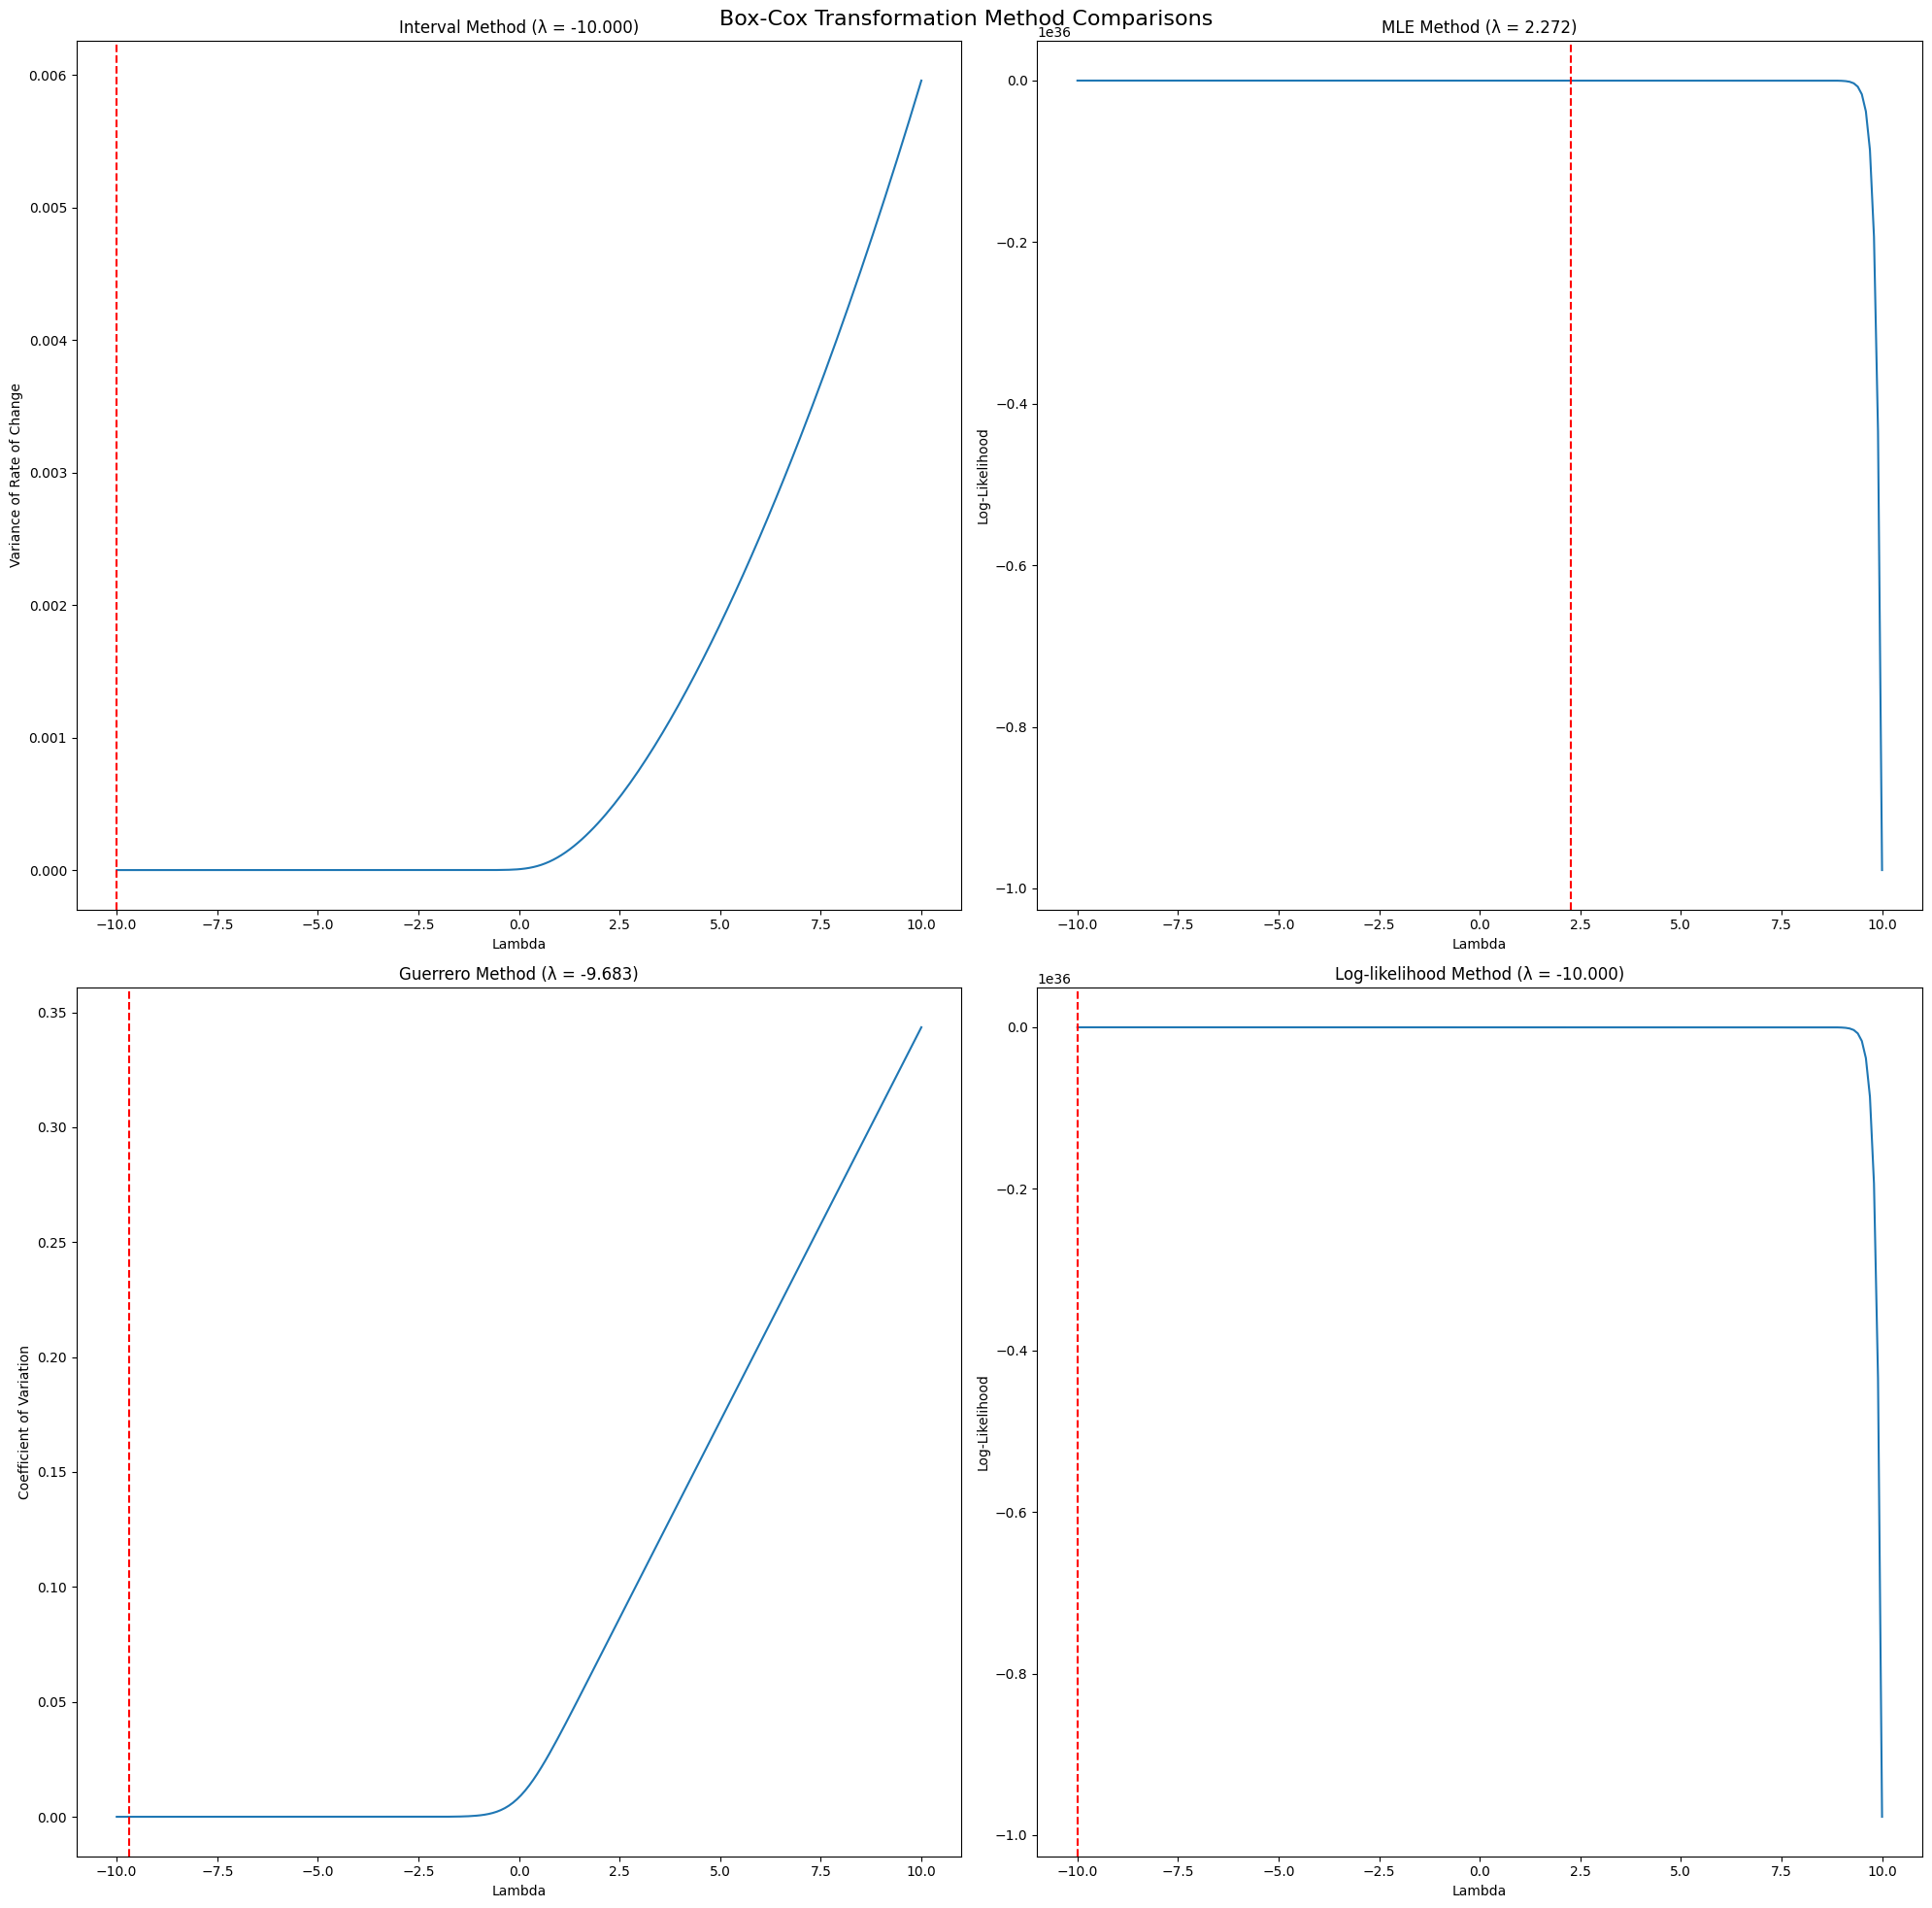

Lambda (Interval Method): -10.000
Lambda (Guerrero Method): -9.683
Lambda (MLE Method): 2.272
Lambda (Log-likelihood Method): -10.000
            Original  Interval  Guerrero          MLE  LogLikelihood
Date                                                                
2000-01-01      64.4       0.1  0.103274  5660.141536            0.1
2000-02-01      64.6       0.1  0.103274  5700.155275            0.1
2000-03-01      64.8       0.1  0.103274  5740.326863            0.1
2000-04-01      65.1       0.1  0.103274  5800.880499            0.1
2000-05-01      64.9       0.1  0.103274  5760.471891            0.1


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import boxcox
from scipy.optimize import minimize_scalar
from statsmodels.stats.diagnostic import het_goldfeldquandt

# [Todas las funciones auxiliares se mantienen igual]
# Function to calculate the variance of the rate of change
def variance_of_rate_of_change(x):
    if len(x) <= 1:
        return np.inf
    return np.var(np.diff(x) / x[:-1])

# Safe Box-Cox function
def safe_boxcox(x, lmbda):
    if np.any(x <= 0):
        return np.full_like(x, np.nan), np.nan
    try:
        if lmbda == 0:
            return np.log(x), 0
        else:
            return (np.power(x, lmbda) - 1) / lmbda, lmbda
    except:
        return np.full_like(x, np.nan), np.nan

# 1. Interval Method
def interval_method(data, lambdas=np.linspace(-10, 10, 200)):
    variances = []
    for l in lambdas:
        transformed, _ = safe_boxcox(data.values, l)
        variances.append(variance_of_rate_of_change(transformed))
    
    valid_variances = [v for v in variances if not np.isinf(v) and not np.isnan(v)]
    if valid_variances:
        min_variance = min(valid_variances)
        optimal_lambda = lambdas[variances.index(min_variance)]
        return optimal_lambda, lambdas, variances
    else:
        return 1.0, lambdas, variances  # Return 1.0 as a default if optimization fails

# 2. Guerrero Method
def guerrero_method(x):
    def cv(l):
        transformed, _ = safe_boxcox(x, l)
        if np.any(np.isnan(transformed)):
            return np.inf
        return np.std(transformed) / np.mean(transformed)
    
    result = minimize_scalar(cv, bounds=(-10, 10), method='bounded')
    return result.x if result.success else 1.0

# 3. Maximum Log-Likelihood Method
def mle_method(data):
    _, lambda_mle = boxcox(data.values)
    return lambda_mle

# Log-Likelihood function
def log_likelihood_method(data):
    lambdas = np.linspace(-10, 10, 200)
    loglikelihoods = []
    for l in lambdas:
        transformed, _ = safe_boxcox(data.values, l)
        if np.any(np.isnan(transformed)):
            loglikelihoods.append(np.nan)
        else:
            loglikelihood = np.sum(stats.norm.logpdf(transformed))
            loglikelihoods.append(loglikelihood)
    
    max_loglike = max(loglikelihoods)
    optimal_lambda = lambdas[loglikelihoods.index(max_loglike)]
    return optimal_lambda, lambdas, loglikelihoods

def apply_transformations(data):
    """
    Apply Box-Cox transformations using different methods and return the transformed series.
    
    Parameters:
    - data: DataFrame containing the original data with the employment rate.
    
    Returns:
    - DataFrame with original and transformed series.
    """
    # Perform analysis
    lambda_interval, _, _ = interval_method(data['Tasa_Empleo_Blancos'])
    lambda_guerrero = guerrero_method(data['Tasa_Empleo_Blancos'].values)
    lambda_mle = mle_method(data['Tasa_Empleo_Blancos'])
    lambda_loglike, _, _ = log_likelihood_method(data['Tasa_Empleo_Blancos'])

    # Apply transformations
    transformed_interval, _ = safe_boxcox(data['Tasa_Empleo_Blancos'].values, lambda_interval)
    transformed_guerrero, _ = safe_boxcox(data['Tasa_Empleo_Blancos'].values, lambda_guerrero)
    transformed_mle, _ = safe_boxcox(data['Tasa_Empleo_Blancos'].values, lambda_mle)
    transformed_loglike, _ = safe_boxcox(data['Tasa_Empleo_Blancos'].values, lambda_loglike)

    # Create DataFrame with original and transformed series
    results = pd.DataFrame({
        'Original': data['Tasa_Empleo_Blancos'],
        'Interval': transformed_interval,
        'Guerrero': transformed_guerrero,
        'MLE': transformed_mle,
        'LogLikelihood': transformed_loglike
    }, index=data.index)

    # Print lambda values for the four methods
    print(f"Lambda (Interval Method): {lambda_interval:.3f}")
    print(f"Lambda (Guerrero Method): {lambda_guerrero:.3f}")
    print(f"Lambda (MLE Method): {lambda_mle:.3f}")
    print(f"Lambda (Log-likelihood Method): {lambda_loglike:.3f}")

    return results

def plot_method_comparisons(data):
    """
    Plot a 4x4 matrix of graphs showing how each method determines its optimal lambda.
    
    Parameters:
    - data: DataFrame containing the original data with the employment rate.
    """
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle('Box-Cox Transformation Method Comparisons', fontsize=16)

    # Generate lambda range
    lambdas = np.linspace(-10, 10, 200)

    # 1. Interval Method
    lambda_interval, _, variances = interval_method(data['Tasa_Empleo_Blancos'])
    
    axs[0, 0].plot(lambdas, variances)
    axs[0, 0].axvline(lambda_interval, color='r', linestyle='--')
    axs[0, 0].set_title(f'Interval Method (λ = {lambda_interval:.3f})')
    axs[0, 0].set_xlabel('Lambda')
    axs[0, 0].set_ylabel('Variance of Rate of Change')

    # 2. Guerrero Method
    lambda_guerrero = guerrero_method(data['Tasa_Empleo_Blancos'].values)
    cvs = [np.std(safe_boxcox(data['Tasa_Empleo_Blancos'].values, l)[0]) / 
           np.mean(safe_boxcox(data['Tasa_Empleo_Blancos'].values, l)[0]) 
           for l in lambdas]
    
    axs[1, 0].plot(lambdas, cvs)
    axs[1, 0].axvline(lambda_guerrero, color='r', linestyle='--')
    axs[1, 0].set_title(f'Guerrero Method (λ = {lambda_guerrero:.3f})')
    axs[1, 0].set_xlabel('Lambda')
    axs[1, 0].set_ylabel('Coefficient of Variation')

    # 3. MLE Method
    lambda_mle = mle_method(data['Tasa_Empleo_Blancos'])
    log_likelihoods = [np.sum(stats.norm.logpdf(safe_boxcox(data['Tasa_Empleo_Blancos'].values, l)[0]))
                       for l in lambdas]
    
    axs[0, 1].plot(lambdas, log_likelihoods)
    axs[0, 1].axvline(lambda_mle, color='r', linestyle='--')
    axs[0, 1].set_title(f'MLE Method (λ = {lambda_mle:.3f})')
    axs[0, 1].set_xlabel('Lambda')
    axs[0, 1].set_ylabel('Log-Likelihood')

    # 4. Log-likelihood Method
    lambda_loglike, _, loglikelihoods = log_likelihood_method(data['Tasa_Empleo_Blancos'])
    
    axs[1, 1].plot(lambdas, loglikelihoods)
    axs[1, 1].axvline(lambda_loglike, color='r', linestyle='--')
    axs[1, 1].set_title(f'Log-likelihood Method (λ = {lambda_loglike:.3f})')
    axs[1, 1].set_xlabel('Lambda')
    axs[1, 1].set_ylabel('Log-Likelihood')

    plt.tight_layout()
    plt.show()

    # Print lambda values for the four methods
    print(f"Lambda (Interval Method): {lambda_interval:.3f}")
    print(f"Lambda (Guerrero Method): {lambda_guerrero:.3f}")
    print(f"Lambda (MLE Method): {lambda_mle:.3f}")
    print(f"Lambda (Log-likelihood Method): {lambda_loglike:.3f}")

# Asumiendo que 'data' es tu DataFrame original
transformed_series = apply_transformations(data)
data['BoxCox_mle'] = transformed_series["MLE"]
plot_method_comparisons(data)
# Mostrar las primeras filas del resultado
print(transformed_series.head())

## Resultados de Lambda

Los valores de lambda obtenidos para cada método son:

- Método de `Intervalo`: λ = -10.000
- Método de `Guerrero`: λ = -9.683
- Método `MLE`: λ = 2.272
- Método de `Log-verosimilitud`: λ = -10.000


## Comparación de las Series Transformadas

Observando los primeros valores de las series transformadas:

- La serie original muestra valores en el rango de 64-65.
- Las transformaciones de Intervalo, Guerrero y Log-verosimilitud producen valores muy pequeños (0.1 o 0.103274), lo que indica una transformación excesiva que podría llevar a una pérdida de información.
- La transformación MLE produce valores mucho más grandes (en el rango de 5600-5800), lo que sugiere una transformación que preserva mejor la estructura de los datos originales.

Dado que el **método MLE** proporciona una transformación más moderada y potencialmente más apropiada, se recomienda utilizar este método (λ = 2.272) para las transformaciones Box-Cox subsecuentes en este conjunto de datos. Este enfoque debería proporcionar una mejor normalización de los datos sin sacrificar demasiado la estructura original de la serie temporal.

In [6]:
plot_("Tasa de empleo en hombres blancos",
      (data.index, data['Tasa_Empleo_Blancos'], 'Original'),
      (data.index, data['BoxCox_mle'], 'Transformed (MLE)'))

# 3. Tendencia

In [7]:

# 2. Estimate trend using LOESS
frac = 0.1
smoothed_values = lowess(data['BoxCox_mle'], np.arange(len(data)), frac=frac)
trend_removed = data['BoxCox_mle'] - smoothed_values[:, 1]
data['trend_removed'] = trend_removed
plot_("Tasa de empleo en hombres blancos", 
      (data.index, data['BoxCox_mle'], 'Box-Cox (MLE)'),
      (data.index, smoothed_values[:, 1], f'LOESS (frac={frac})'),
      (data.index, trend_removed, 'Trend-Removed'))

In [8]:
%R -i data

Además: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


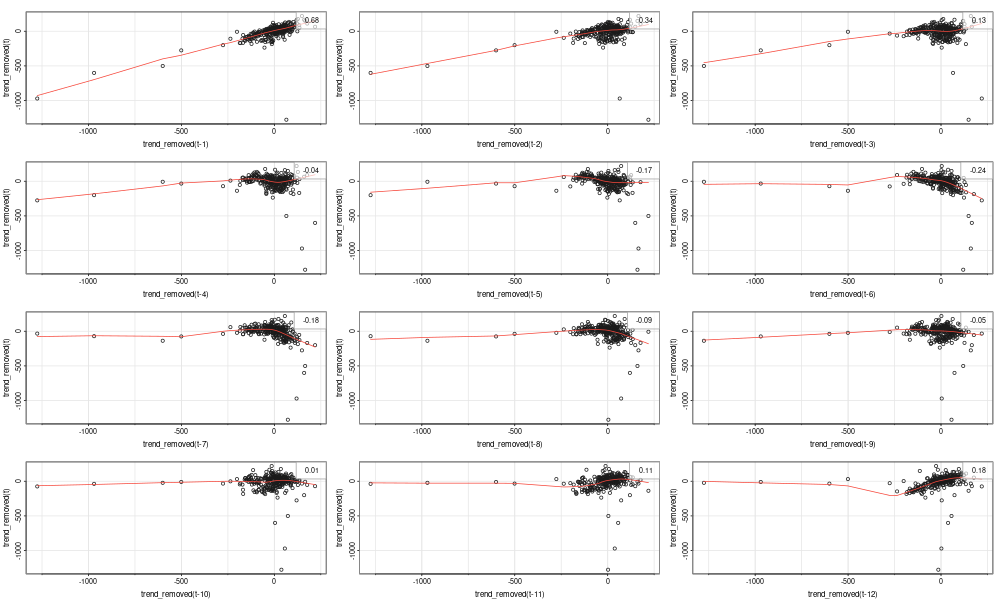

In [9]:
%%R -w 1000 -h 600

trend_removed <- data$trend_removed

options(repr.plot.width=20, repr.plot.height=6)
library(astsa)
astsa::lag1.plot(trend_removed, 12)

##  **Análisis Gráficos de Dispersión de Rezagos**

🔹 Los gráficos muestran la relación entre la serie de tiempo y sus rezagos, destacando una fuerte autocorrelación **positiva** en los primeros rezagos (lags: 1, 2 y 3) y fuerte autocorrelación **negativa** de (lags: 5,6 y 7). Algunos valores atípicos sugieren la presencia de eventos inusuales o extremos.


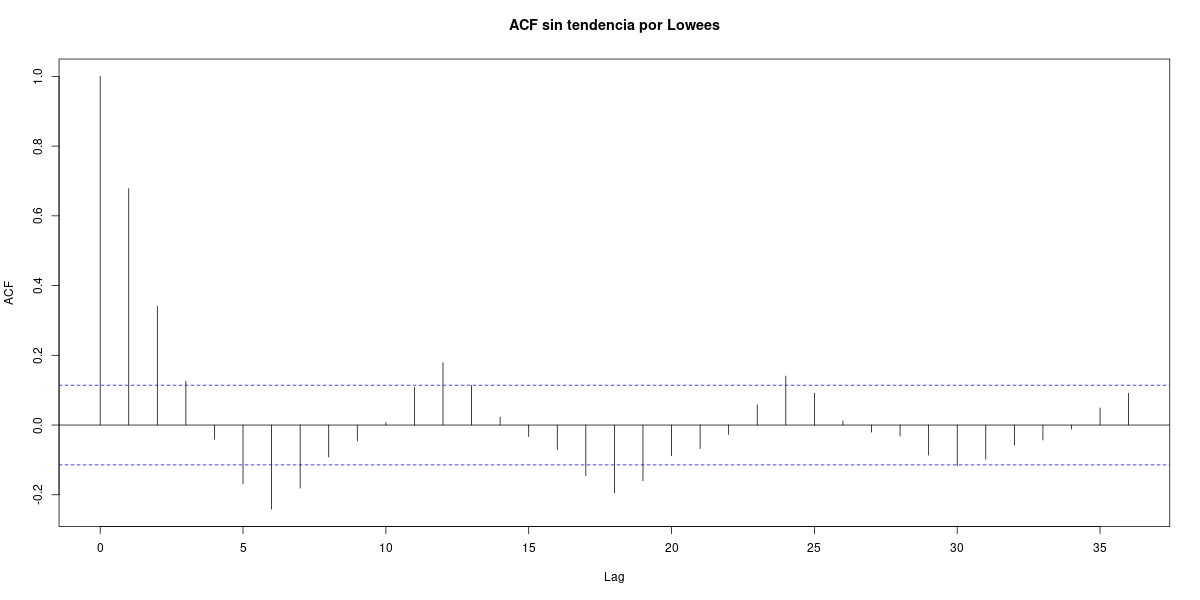

In [10]:
%%R -w 1200 -h 600

acf(trend_removed, lag.max = 36, main = "ACF sin tendencia por Lowees")

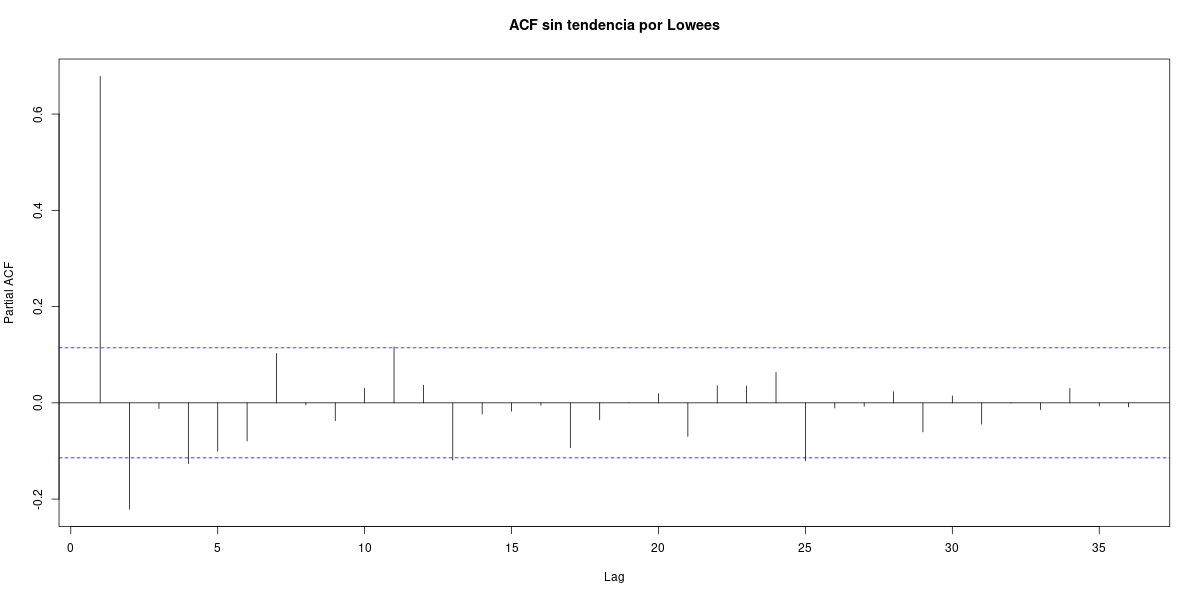

In [11]:
%%R -w 1200 -h 600

pacf(trend_removed, lag.max = 36, main = "ACF sin tendencia por Lowees")

$time.lag
 [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
[26] 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
[51] 50

$mutual.information
 [1]  0.69624740  0.19841056  0.07865461  0.04822238  0.05154814  0.06188565
 [7]  0.05336300  0.04732377  0.05719921  0.03493614  0.02207820  0.07902610
[13]  0.13775805  0.07854255  0.02227836  0.03401285  0.06621189  0.06899587
[19]  0.08115069  0.05970750  0.04170459  0.02429756  0.01569382  0.09235058
[25]  0.14928529  0.08371837  0.02425410  0.03820748  0.07480323  0.07543917
[31]  0.07197960  0.06204323  0.05399296  0.03411952  0.03786940  0.10438116
[37]  0.16216894  0.07497335  0.03349767  0.05326243  0.06967454  0.07985365
[43]  0.07006121  0.06640396  0.05496780  0.03272447  0.03281495  0.09751118
[49]  0.11669200  0.02879762 -0.05742453

$units
[1] "Nats"

$n.partitions
[1] 6

attr(,"class")
[1] "mutualInf"


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


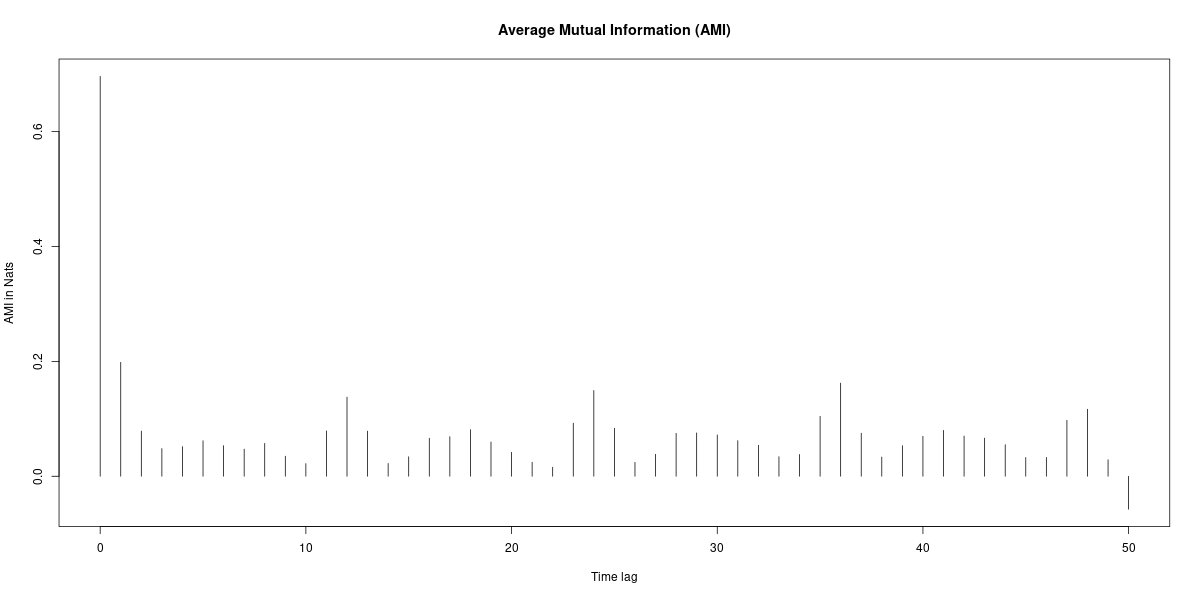

In [12]:
%%R -w 1200 -h 600
nonlinearTseries::mutualInformation(trend_removed,lag.max = 50, main="Información mutua")

# 4. Estacionalidad

Se va a realizar un análisis de estacionalidad para determinar si la serie temporal presenta un patrón estacional significativo, para ello se considera para la mejor interpretabilidad remover el outliner que se ha observado en la serie.

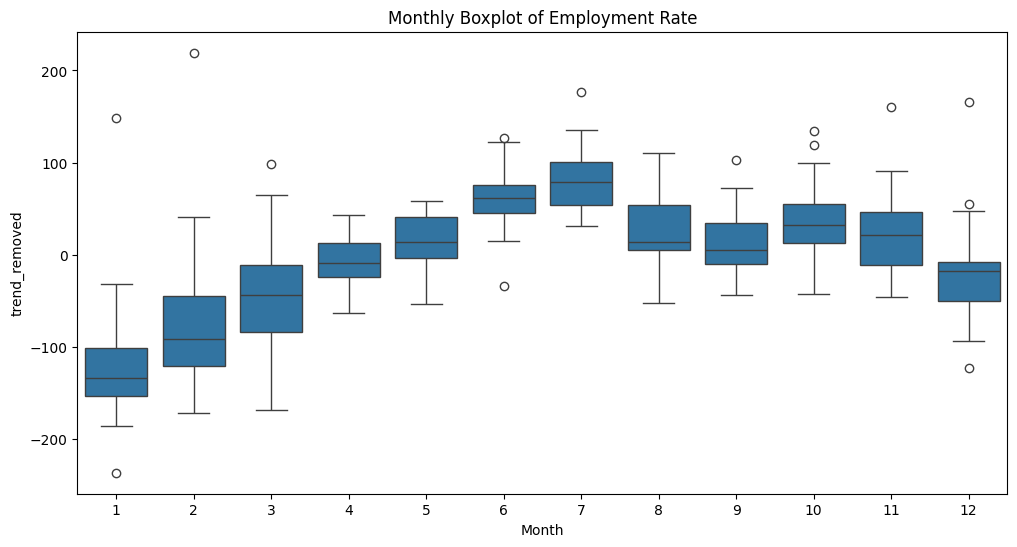

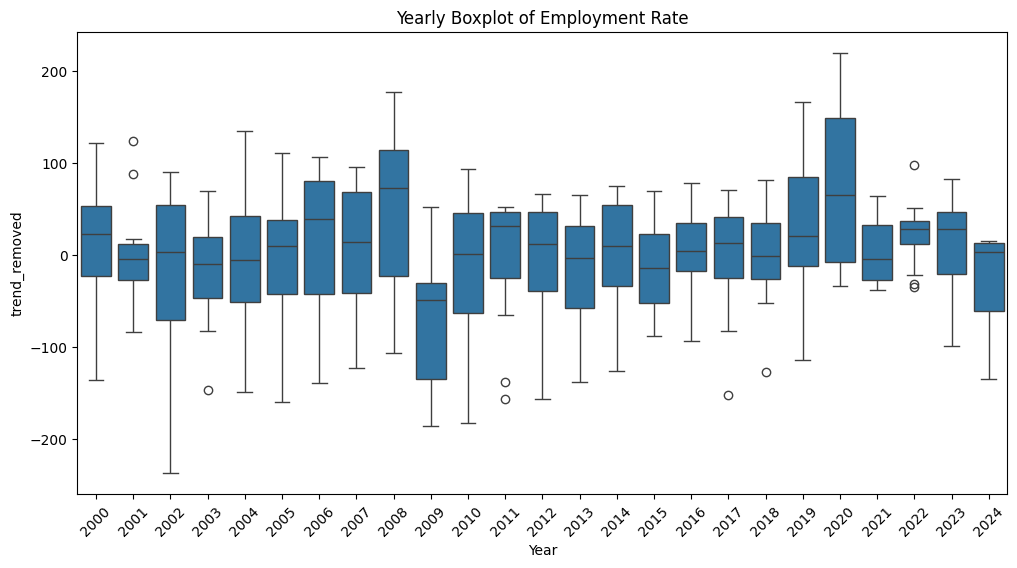

In [13]:

# 4. Examine seasonality
data['Month'] = data.index.month
data['Year'] = data.index.year

data_no_outliner = data[data['Tasa_Empleo_Blancos'] >= 58].copy()


plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='trend_removed', data=data_no_outliner)
plt.title('Monthly Boxplot of Employment Rate')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='trend_removed', data=data_no_outliner)
plt.title('Yearly Boxplot of Employment Rate')
plt.xticks(rotation=45)
plt.show()



## Analisis por Mediana

Al observar el comportamiento de la mediana en los diferentes meses se encuentran picos en Julio y Noviembre y valles en Enero y Septiembre. Este comportamiento daría pie a pensar de una <span style="color:yellow">posible estacionalidad </span>.

In [14]:
%R -i data_no_outliner

In [15]:
%%R 

# Add a new column 'Date' from the index
data$Date <- rownames(data)
data_no_outliner$Date <- rownames(data_no_outliner)

# Convert the new 'Date' column to Date class
data$Date <- as.Date(data$Date)
data_no_outliner$Date <- as.Date(data_no_outliner$Date)

# Move the 'Date' column to the first position
data <- data[, c("Date", setdiff(names(data), "Date"))]
data_no_outliner <- data_no_outliner[, c("Date", setdiff(names(data_no_outliner), "Date"))]


Además: There were 36 warnings (use warnings() to see them)


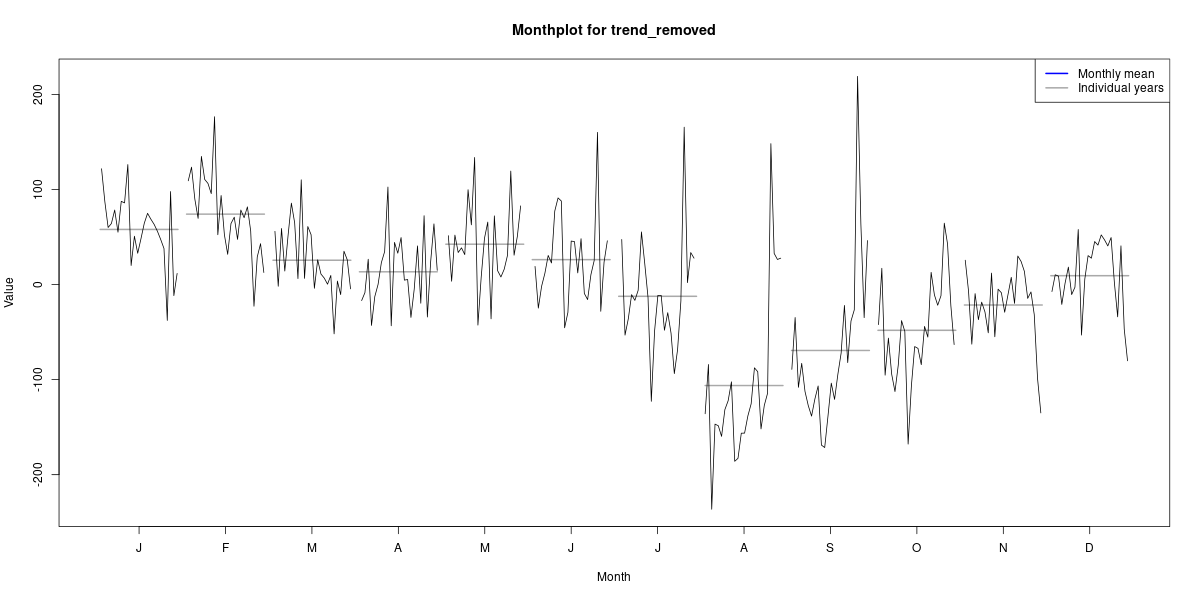

In [16]:
%%R -w 1200 -h 600

# Convert trend_removed to a time series object
trend_removed_ts <- ts(data_no_outliner$trend_removed, start = data_no_outliner$Date, frequency = 12)
# Convert trend_removed to a time series object
# Create the monthplot
monthplot(trend_removed_ts, main = 'Monthplot for trend_removed', 
          ylab = 'Value', xlab = 'Month',
          col.base = "darkgray", col.lines = "blue",
          lwd.base = 2, lwd.lines = 2)

# Add a legend
legend("topright", legend = c("Monthly mean", "Individual years"),
       col = c("blue", "darkgray"), lty = 1, lwd = 2)

## Analisis por Media

Al observar el comportamiento de la mediana en los diferentes meses se encuentran picos en Febrero y Mayo y valles en Abril y Agosto. Este comportamiento daría pie a pensar de una <span style="color:yellow">posible estacionalidad </span>.

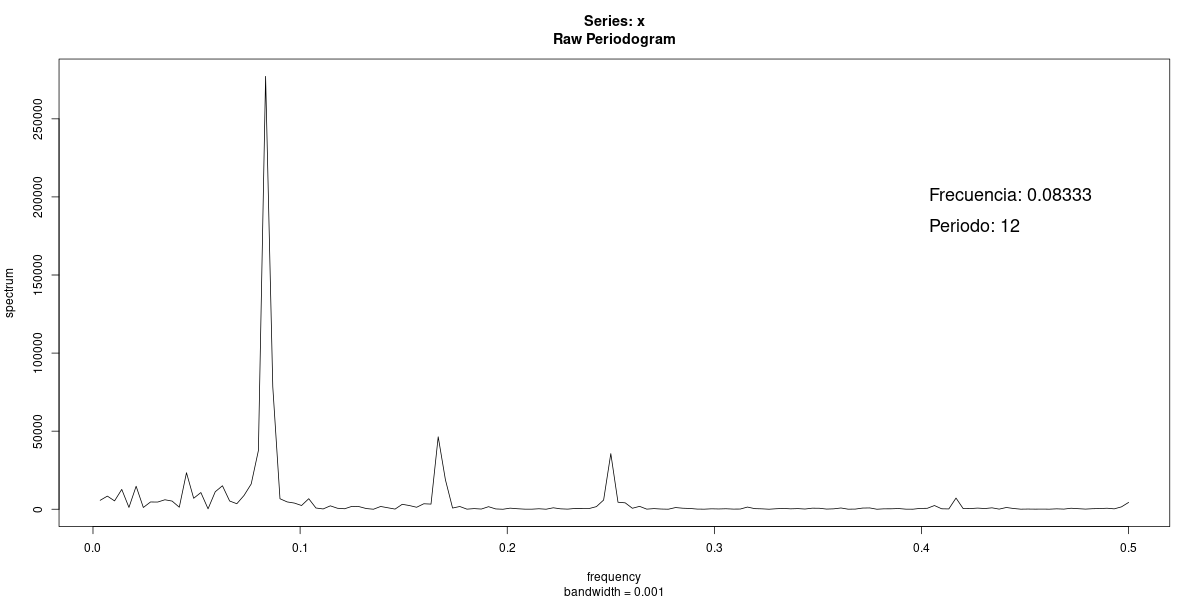

In [19]:
%%R -w 1200 -h 600

# Calculate the periodogram for data2
Periogram <- spectrum(as.numeric(trend_removed_ts), log = 'no')

# Get the index where the periodogram maximizes
ubicacion <- which.max(Periogram$spec)

# Get the frequency value at the index where the periodogram maximizes
max_freq <- Periogram$freq[ubicacion]

# Calculate the corresponding period
max_period <- 1 / max_freq

# Plot the periodogram for data2

# Add text annotation for frequency and period
text(.4, 200000, sprintf("Frecuencia: %s", round(max_freq, 5)), pos = 4, cex = 1.5)
text(.4, 180000, sprintf("Periodo: %s", round(max_period, 2)), pos = 4, cex = 1.5)

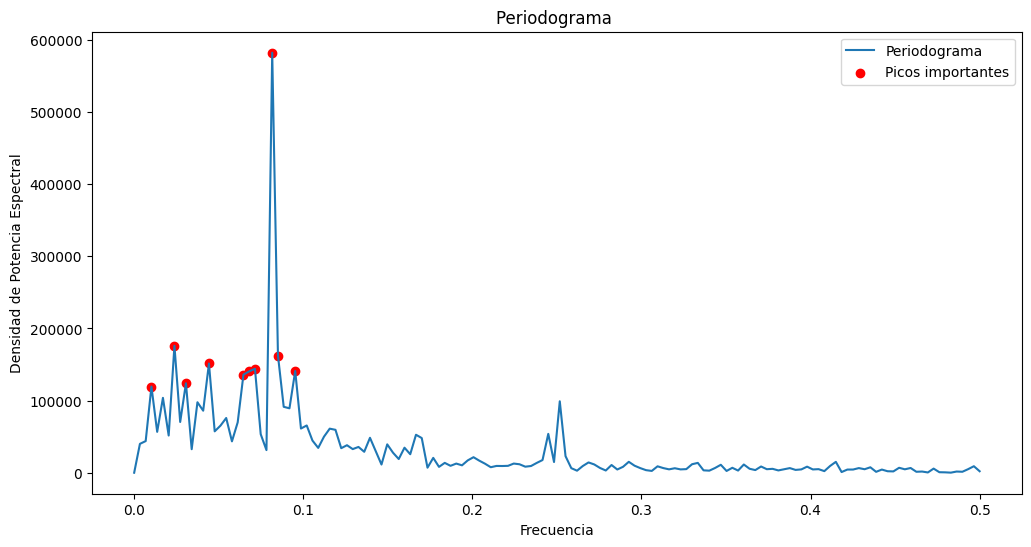

Los 10 Picos mas grandes para el periodograma son:


,0,1,2,3,4,5,6,7,8,9
Frecuencia,0.081633,0.023810,0.085034,0.044218,0.071429,0.095238,0.068027,0.064626,0.030612,0.010204
Periodo,12.250000,42.000000,11.760000,22.615385,14.000000,10.500000,14.700000,15.473684,32.666667,98.000000
Densidad de Potencia Espectral,582303.753234,175999.209738,162508.765089,151437.955889,144115.921105,141103.884731,140516.294386,135995.630391,123996.642753,119432.513032


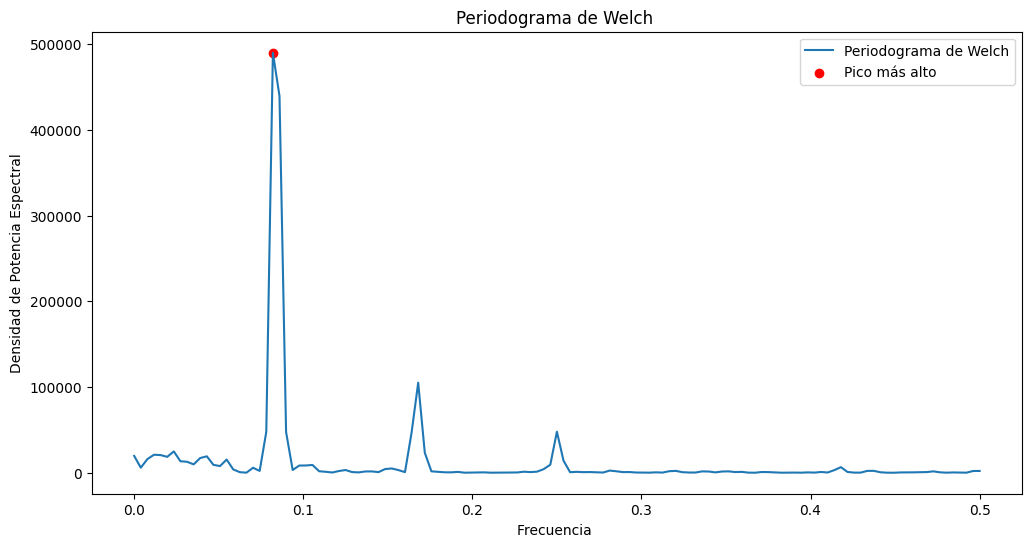

El pico más notorio se da: 
 - Frecuencia: 0.08203125  
                                    
 - Periodo: 12.19047619047619 
                                    
 - Densidad de Potencia Espectral: 490134.26989427244


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import heapq


# Calcular el periodograma
f, Pxx_den = signal.periodogram(trend_removed)

# Encontrar los picos más importantes
peaks_indices = heapq.nlargest(10, range(len(Pxx_den)), key=Pxx_den.__getitem__)
f_freq = f[peaks_indices]
densidad = Pxx_den[peaks_indices]
f_period = 1 / f[peaks_indices]

# Calcular el periodograma de Welch
f_welch, Pxx_den_welch = signal.welch(trend_removed)

# Encontrar el pico más alto del periodograma de Welch
max_index_value_welch = np.argmax(Pxx_den_welch)
frecuencia_max_welch = f_welch[max_index_value_welch]
frecuencia_pico_welch = 1 / frecuencia_max_welch




# Graficar el periodograma
plt.figure(figsize=(12, 6))
plt.plot(f, Pxx_den, label='Periodograma')
plt.scatter(f[peaks_indices], Pxx_den[peaks_indices], color='red', label='Picos importantes')

plt.xlabel('Frecuencia')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma ')
plt.legend()
plt.show()

print('Los 10 Picos mas grandes para el periodograma son:')

# Crear DataFrame con las frecuencias y los periodos
data = {'Frecuencia': f_freq, 'Periodo': f_period, 'Densidad de Potencia Espectral': densidad}
df_frecuencias_periodos = pd.DataFrame(data).sort_values(by='Densidad de Potencia Espectral', ascending=False)

# Mostrar el DataFrame
display(df_frecuencias_periodos.T)

# Graficar el periodograma de Welch
plt.figure(figsize=(12, 6))
plt.plot(f_welch, Pxx_den_welch, label='Periodograma de Welch')
plt.scatter(frecuencia_max_welch, Pxx_den_welch[max_index_value_welch], color='red', label='Pico más alto')

plt.xlabel('Frecuencia ')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma de Welch ')
plt.legend()
plt.show()

print(f"""El pico más notorio se da: \n - Frecuencia: {frecuencia_max_welch}  
                                    \n - Periodo: {frecuencia_pico_welch} 
                                    \n - Densidad de Potencia Espectral: {Pxx_den_welch[max_index_value_welch]}""")

Por medio de los periodogramas se observa finalmente que la serie tiene un <span style="color:yellow">periodo de 12 meses </span>, lo que confirma la presencia de estacionalidad en la serie.

# 5. Modelación RNN

Se va a tomar `lag =3` por el ACF

In [11]:
import matplotlib.pyplot as plt
import warnings
import rpy2
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import statsmodels.api as sm

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext rpy2.ipython

In [9]:


def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Precio en dolares"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()

In [3]:
df = pd.read_csv("./data/Base_de_datos_Parcial - Hoja1.csv")
df = df[["Year_Month", "Tasa de Empleo en hombres Blancos"]]
df = df.rename(columns={"Year_Month": "Date", "Tasa de Empleo en hombres Blancos": "Tasa_Empleo_Blancos"})
df['Date'] = pd.to_datetime(df['Date'])

plot_("Tasa de empleo en hombres blancos",
      (df['Date'], df['Tasa_Empleo_Blancos'], 'Tasa de empleo en hombres blancos'))

/tmp/ipykernel_256983/1689384552.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Entrenamiento - MSE: 0.3750, R2: 0.9218
Validación - MSE: 0.0233, R2: -0.7174
Prueba - MSE: 0.0896, R2: 0.1964
Resultados de Grid Search:


,units,activation,val_mse
0,8,tanh,0.005464
1,8,relu,0.005432
2,32,tanh,0.004788
3,32,relu,0.008157


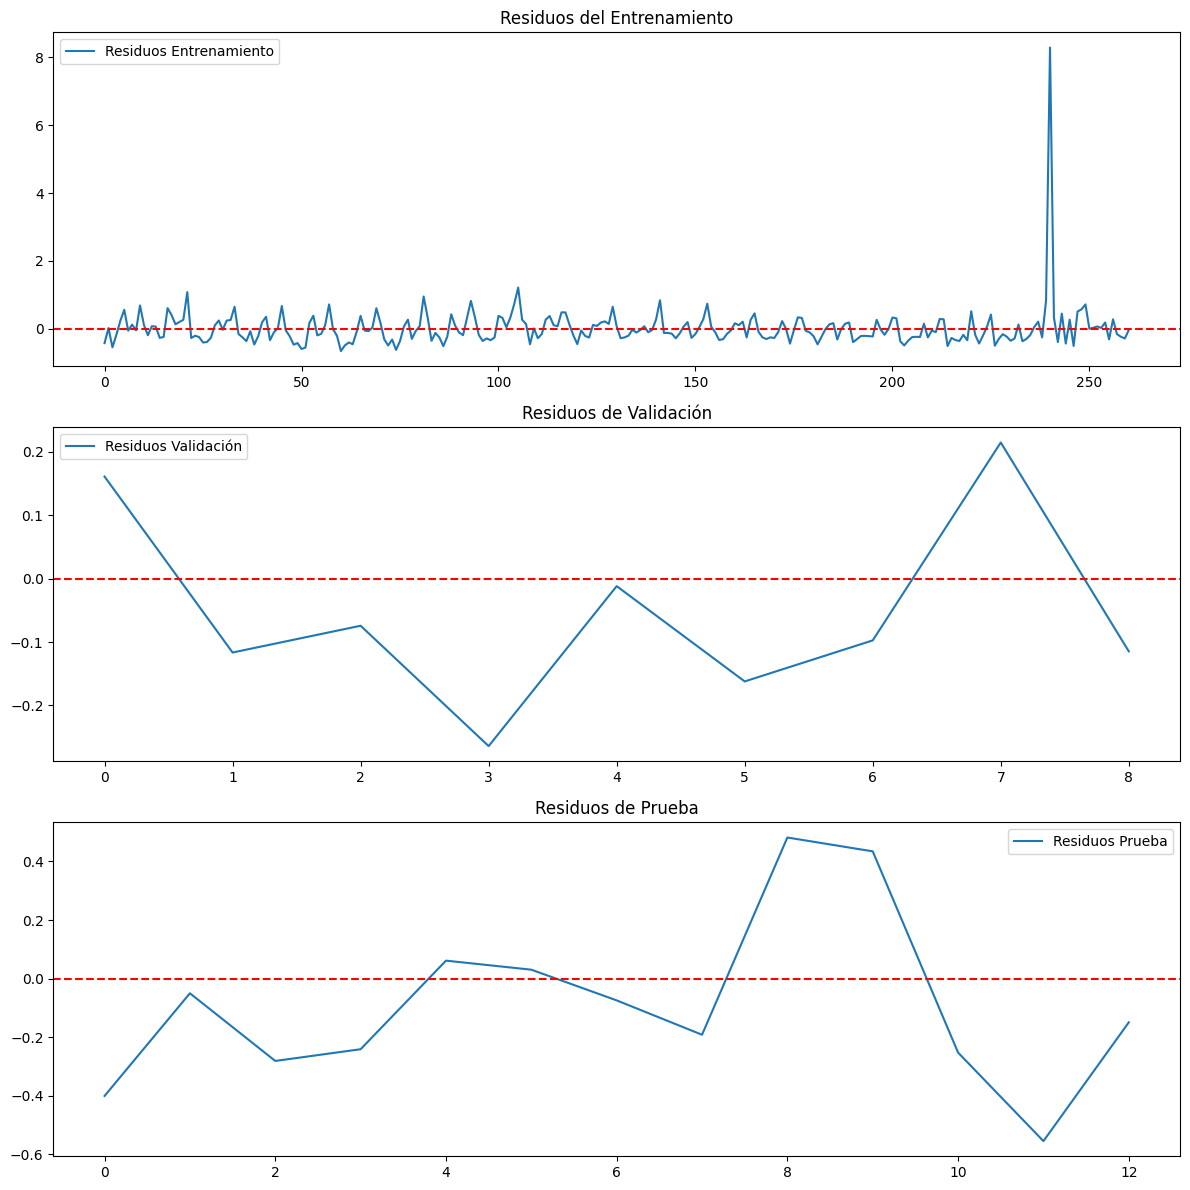

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

def create_sequences(data, lag):
    """Crea secuencias de datos para entrenamiento."""
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i + lag])
        y.append(data[i + lag])
    return np.array(X), np.array(y)

def build_model(units, activation):
    """Crea y compila el modelo LSTM."""
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(lag, 1)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Cargar y preprocesar datos
df = pd.read_csv("./data/Base_de_datos_Parcial - Hoja1.csv")
df = df[["Year_Month", "Tasa de Empleo en hombres Blancos"]]
df = df.rename(columns={"Year_Month": "Date", "Tasa de Empleo en hombres Blancos": "Tasa_Empleo_Blancos"})
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Dividir en conjuntos de entrenamiento, validación y prueba
train = df[:'2021-12']
val = df['2022-01':'2022-12']
test = df['2023-01':'2024-04']

# Escalar datos
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train['Tasa_Empleo_Blancos'].values.reshape(-1, 1))
val_scaled = scaler.transform(val['Tasa_Empleo_Blancos'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['Tasa_Empleo_Blancos'].values.reshape(-1, 1))

# Crear secuencias
lag = 3  # Ajusta el lag según sea necesario
X_train, y_train = create_sequences(train_scaled, lag)
X_val, y_val = create_sequences(val_scaled, lag)
X_test, y_test = create_sequences(test_scaled, lag)

# Reshape para LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Definir hiperparámetros para Grid Search
param_grid = {
    'units': [8, 32],
    'activation': ['tanh', 'relu']
}

best_model = None
best_score = float('inf')
results = []

# Realizar Grid Search
for units in param_grid['units']:
    for activation in param_grid['activation']:
        model = build_model(units, activation)
        model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0)
        
        # Evaluar el modelo en el conjunto de validación
        val_pred = model.predict(X_val)
        val_loss = mean_squared_error(y_val, val_pred)
        
        # Guardar resultados
        results.append({
            'units': units,
            'activation': activation,
            'val_mse': val_loss
        })
        
        # Guardar el mejor modelo
        if val_loss < best_score:
            best_score = val_loss
            best_model = model

# Hacer predicciones
train_pred = best_model.predict(X_train)
val_pred = best_model.predict(X_val)
test_pred = best_model.predict(X_test)

# Inversar la transformación para obtener los valores originales
train_pred = scaler.inverse_transform(train_pred)
val_pred = scaler.inverse_transform(val_pred)
test_pred = scaler.inverse_transform(test_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluar modelo
def evaluate_model(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{set_name} - MSE: {mse:.4f}, R2: {r2:.4f}")
    return y_pred - y_true  # Retornar residuos

train_residuals = evaluate_model(y_train_inv, train_pred, "Entrenamiento")
val_residuals = evaluate_model(y_val_inv, val_pred, "Validación")
test_residuals = evaluate_model(y_test_inv, test_pred, "Prueba")

# Crear un DataFrame para los resultados de Grid Search
results_df = pd.DataFrame(results)
print("Resultados de Grid Search:")
display(results_df)

# Análisis de residuos
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(train_residuals, label='Residuos Entrenamiento')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos del Entrenamiento')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_residuals, label='Residuos Validación')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos de Validación')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(test_residuals, label='Residuos Prueba')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos de Prueba')
plt.legend()

plt.tight_layout()
plt.show()


### Note:

Que el `Prueba - MSE: 0.0896, R2: 0.1964`

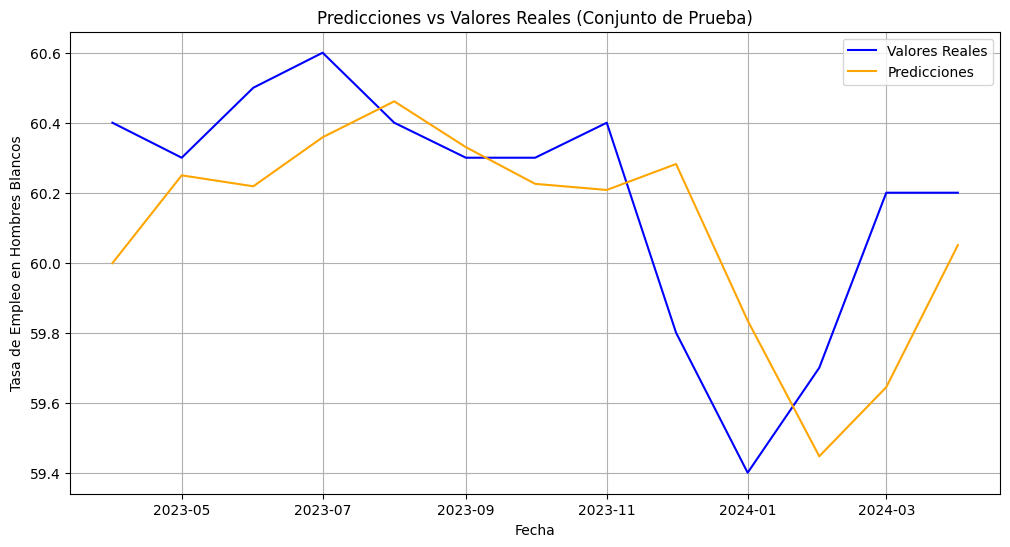

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(test.index[lag:], y_test_inv, label='Valores Reales', color='blue')
plt.plot(test.index[lag:], test_pred, label='Predicciones', color='orange')
plt.title('Predicciones vs Valores Reales (Conjunto de Prueba)')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Empleo en Hombres Blancos')
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_6006/1894757957.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/home/plealm/Documentos/Unal/Maestria/1_Semestre/Series_Temporales/codigo/acciones/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6878
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2938
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1881
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0723
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0996
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1260
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1184
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1062
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0901
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0814
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1783
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0872
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1176
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2037
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2751
Epoch 16/50
30/30 ━

/tmp/ipykernel_6006/1894757957.py:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=2, freq='M')


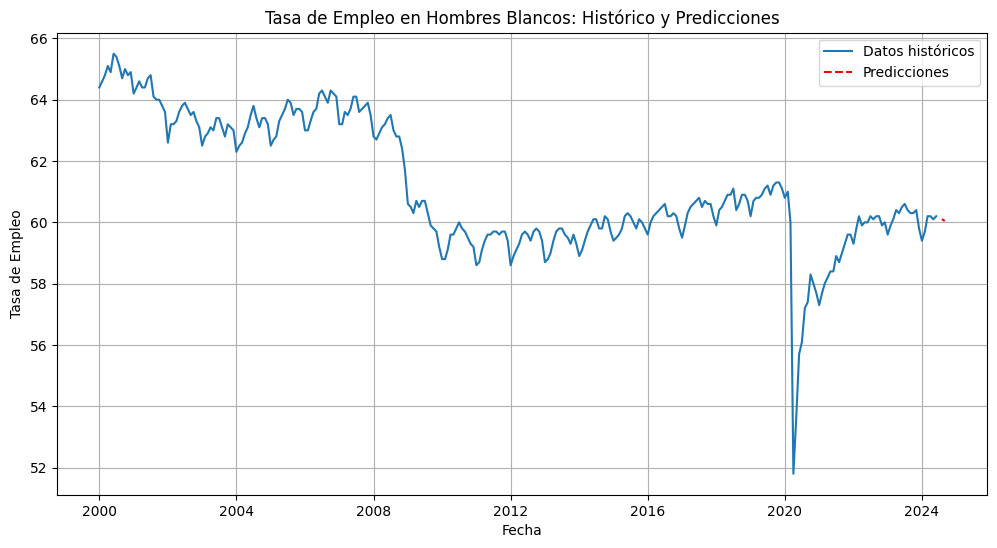

In [2]:

# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Funciones auxiliares
def create_sequences(data, lag):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i + lag])
        y.append(data[i + lag])
    return np.array(X), np.array(y)

def build_model(units, activation, input_shape):
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Cargar y preprocesar datos
df = pd.read_csv("./data/Base_de_datos_Parcial - Hoja1.csv")
df = df[["Year_Month", "Tasa de Empleo en hombres Blancos"]]
df = df.rename(columns={"Year_Month": "Date", "Tasa de Empleo en hombres Blancos": "Tasa_Empleo_Blancos"})
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Escalar datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df['Tasa_Empleo_Blancos'].values.reshape(-1, 1))

# Crear secuencias
lag = 3
X, y = create_sequences(data_scaled, lag)

# Reshape para LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Construir y entrenar el mejor modelo (usando los mejores hiperparámetros encontrados)
best_units = 32  # Asumiendo que este fue el mejor resultado del grid search
best_activation = 'tanh'  # Asumiendo que este fue el mejor resultado del grid search

best_model = build_model(best_units, best_activation, (lag, 1))
best_model.fit(X, y, epochs=50, batch_size=10, verbose=1)

# Preparar datos para la predicción
last_sequence = data_scaled[-lag:].reshape(1, lag, 1)

# Realizar predicciones para h=2
predictions = []
for _ in range(2):
    next_pred = best_model.predict(last_sequence)
    predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1, 0] = next_pred

# Invertir la escala de las predicciones
predictions_original = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Crear fechas para las predicciones
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=2, freq='M')

# Crear un DataFrame con las predicciones
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Tasa_Empleo_Blancos': predictions_original.flatten()
})
predictions_df.set_index('Date', inplace=True)

# Mostrar las predicciones
print("Predicciones para los próximos 2 meses:")
print(predictions_df)

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Tasa_Empleo_Blancos'], label='Datos históricos')
plt.plot(predictions_df.index, predictions_df['Predicted_Tasa_Empleo_Blancos'], 'r--', label='Predicciones')
plt.title('Tasa de Empleo en Hombres Blancos: Histórico y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Empleo')
plt.legend()
plt.grid(True)
plt.show()

### El valor esperado dos meses despues es : 2024-08-31                      60.044426